## Project Topic: 

## **Predictive Maintenance for Li-ion Batteries Using Time Series Data**

Presenters: Jayden Li and Zheng Fang

## 1. Introduction

### Project Motivation
- The rapid adoption of electric vehicles and renewable energy storage systems demands longer-lasting and more reliable lithium-ion batteries. To achieve better endurance and performance, a rigorous battery monitoring system is essential.  

- Battery degradation leads to costly maintenance, unpredictable failures, and safety risks if not properly monitored.  

- Predicting degradation trends using data-driven methods enables proactive maintenance and sustainable energy management.


### Business Value
- Reliable battery health prediction minimizes unexpected failures and warranty costs.  

- Data-driven insights allow manufacturers to optimize production and quality control.  

- Predictive analytics improve fleet management and enhance user satisfaction.  

### Decisions to be Impacted
This analysis aims to support decisions related to:
- Maintenance scheduling  
- Battery replacement policies  
- Reliability optimization  

### Why We Care
- Battery systems are a key component in the global transition to clean energy.  

- Combining data analytics with electrochemical understanding provides actionable insights.  

- This project bridges engineering and data science to address real-world sustainability challenges.


## 2. Data and Data Preprocessing

### 2.1 Dataset Overview
- The dataset contains **six folders**, each including several `.mat` files.  
- Each `.mat` file represents **one battery**, which records multiple **charge–discharge cycles** collected under specific experimental conditions.  
- Every **cycle** contains two parts:
  - `charge` phase  
  - `discharge` phase  
- Each phase includes several time-series features, such as:
  - Voltage_measured  
  - Current_measured  
  - Temperature_measured  
  - (For discharge only) Capacity

### 2.2 Data Consolidation
To enable data analysis across all batteries, we created a preprocessing script (`preprocessing_battery_data_csv.py`) to extract statistical features from each `.mat` file:
- For each feature (voltage, current, temperature), we computed **average**, **minimum**, and **maximum** values over time.  
- This is possible because each measurement is a time series; summarizing with statistical descriptors captures the overall trend of each cycle.  
- Each row in the final dataset represents **one full charge–discharge cycle** for a given battery.  
- The final combined dataset is saved as `battery_cycles_summary.csv`.  

### 2.3 Label Definition
- The target variable (label) is **discharge capacity** (`capacity_Ah`), representing the battery’s available capacity in ampere-hours.  
- Additionally, a derived variable **RUL (Remaining Useful Life)** is computed for each battery as:  
    - RUL = $\text{max(cycle)} - \text{current cycle}$
 
- RUL provides a cycle-based estimate of how many charge–discharge cycles remain before the battery reaches its end of life.

### 2.4 Outlier Detection
- We applied **IQR (Interquartile Range)** method to detect outliers in the `capacity_Ah` feature for each battery.  
- Outliers beyond 1.5×IQR from the Q1–Q3 range were flagged and visualized on the capacity–cycle plots.  
- These outliers were either removed or replaced with interpolated values for smooth capacity degradation curves.

In [22]:
!python Preprocessing/preprocessing_battery_data_csv.py

B0005: Successfully matched 168 charge+discharge pairs.
B0006: Successfully matched 168 charge+discharge pairs.
B0007: Successfully matched 168 charge+discharge pairs.
B0018: Successfully matched 132 charge+discharge pairs.
B0025: Successfully matched 28 charge+discharge pairs.
B0026: Successfully matched 28 charge+discharge pairs.
B0027: Successfully matched 28 charge+discharge pairs.
B0028: Successfully matched 28 charge+discharge pairs.
B0025: Successfully matched 28 charge+discharge pairs.
B0026: Successfully matched 28 charge+discharge pairs.
B0027: Successfully matched 28 charge+discharge pairs.
B0028: Successfully matched 28 charge+discharge pairs.
B0029: Successfully matched 40 charge+discharge pairs.
B0030: Successfully matched 40 charge+discharge pairs.
B0031: Successfully matched 40 charge+discharge pairs.
B0032: Successfully matched 40 charge+discharge pairs.
B0033: Successfully matched 197 charge+discharge pairs.
B0034: Successfully matched 197 charge+discharge pairs.
B003

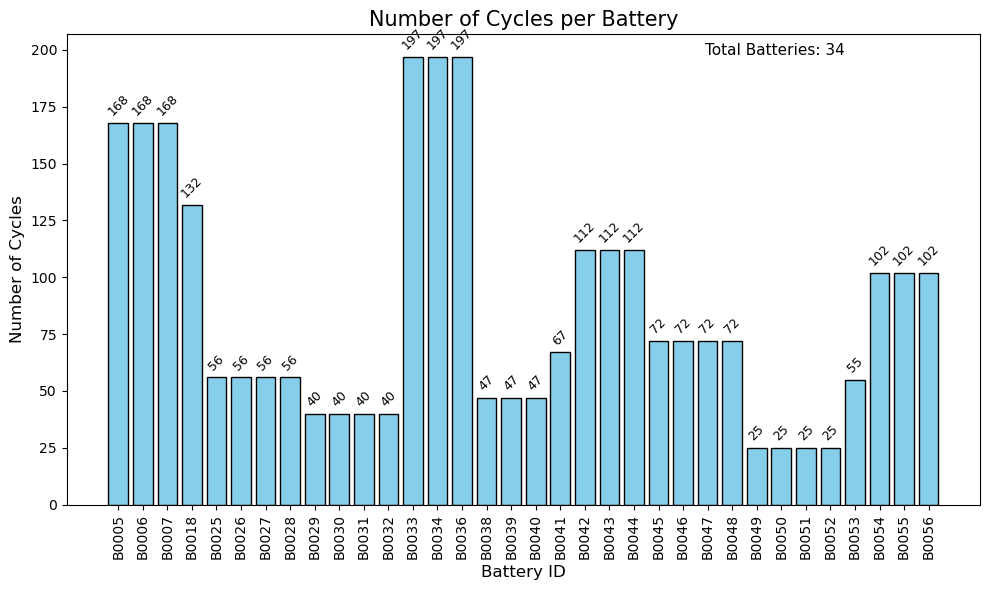

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Data/battery_cycles_summary.csv")

# Count number of cycles per battery
cycle_counts = df["battery"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(cycle_counts.index, cycle_counts.values, color="skyblue", edgecolor="black")

plt.title("Number of Cycles per Battery", fontsize=15)
plt.xlabel("Battery ID", fontsize=12)
plt.ylabel("Number of Cycles", fontsize=12)

# Plot bar chart
plt.xticks(rotation=90)

# Annotate values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{int(height)}",
             ha="center", va="bottom", rotation=45, fontsize=9)

# Add total battery count
total_batteries = df["battery"].nunique()
plt.figtext(0.85, 0.9, f"Total Batteries: {total_batteries}", fontsize=11, ha="right")

plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

df = pd.read_csv("Data/battery_cycles_summary.csv")
num_features = len(df.columns)

print("Total number of features (columns):", num_features)
print("Feature names:")
print(list(df.columns))


Total number of features (columns): 24
Feature names:
['battery', 'cycle', 'charge_voltage_avg', 'charge_voltage_min', 'charge_voltage_max', 'charge_current_avg', 'charge_current_min', 'charge_current_max', 'charge_temp_avg', 'charge_temp_min', 'charge_temp_max', 'charge_duration_s', 'discharge_voltage_avg', 'discharge_voltage_min', 'discharge_voltage_max', 'discharge_current_avg', 'discharge_current_min', 'discharge_current_max', 'discharge_temp_avg', 'discharge_temp_min', 'discharge_temp_max', 'discharge_duration_s', 'capacity_Ah', 'RUL']


In [25]:
df.head()

,battery,cycle,charge_voltage_avg,charge_voltage_min,charge_voltage_max,charge_current_avg,charge_current_min,charge_current_max,charge_temp_avg,charge_temp_min,...,discharge_voltage_max,discharge_current_avg,discharge_current_min,discharge_current_max,discharge_temp_avg,discharge_temp_min,discharge_temp_max,discharge_duration_s,capacity_Ah,RUL
0,B0005,1,4.187420,3.479394,4.209949,0.643455,-4.030268,1.514393,25.324079,24.167062,...,4.191492,-1.818702,-2.018015,0.000729,32.572328,24.325993,38.982181,3690.234,1.856487,167
1,B0005,2,4.058826,3.001951,4.213016,0.949043,-3.361983,1.515178,26.635623,24.528515,...,4.189773,-1.817560,-2.016821,0.002927,32.725235,24.685948,39.033398,3672.344,1.846327,166
2,B0005,3,4.058139,3.035879,4.212788,0.950529,-3.384408,1.516894,26.778176,24.600174,...,4.188187,-1.816487,-2.016574,0.001484,32.642862,24.734266,38.818797,3651.641,1.835349,165
3,B0005,4,4.058905,3.066145,4.212924,0.952312,-3.412263,1.517503,26.703204,24.493346,...,4.188461,-1.825589,-2.015936,0.001547,32.514876,24.652244,38.762305,3631.563,1.835263,164
4,B0005,5,4.058330,3.063766,4.212874,0.947728,-3.403625,1.516949,26.617004,24.420170,...,4.188299,-1.826114,-2.017426,0.001701,32.382349,24.518700,38.665393,3629.172,1.834646,163


### 2.5 Summary of Final Dataset
| Item | Description |
|------|--------------|
| Total batteries | 34 |
| Total cycles | varies per battery (~25–197) |
| Features per cycle | ≈ 24 (including avg/min/max of voltage, current, temperature, etc. and Labels) |
| Label | Capacity (Ah) |
| Derived feature | RUL (Remaining Useful Life) |

**After Data Preprocessing**

Unique total cycle counts found: [np.int64(25), np.int64(28), np.int64(40), np.int64(47), np.int64(55), np.int64(67), np.int64(72), np.int64(102), np.int64(112), np.int64(132), np.int64(168), np.int64(197)]
Total unique groups: 12
This is raw data demonstraion between Capacity and Number of Cycles


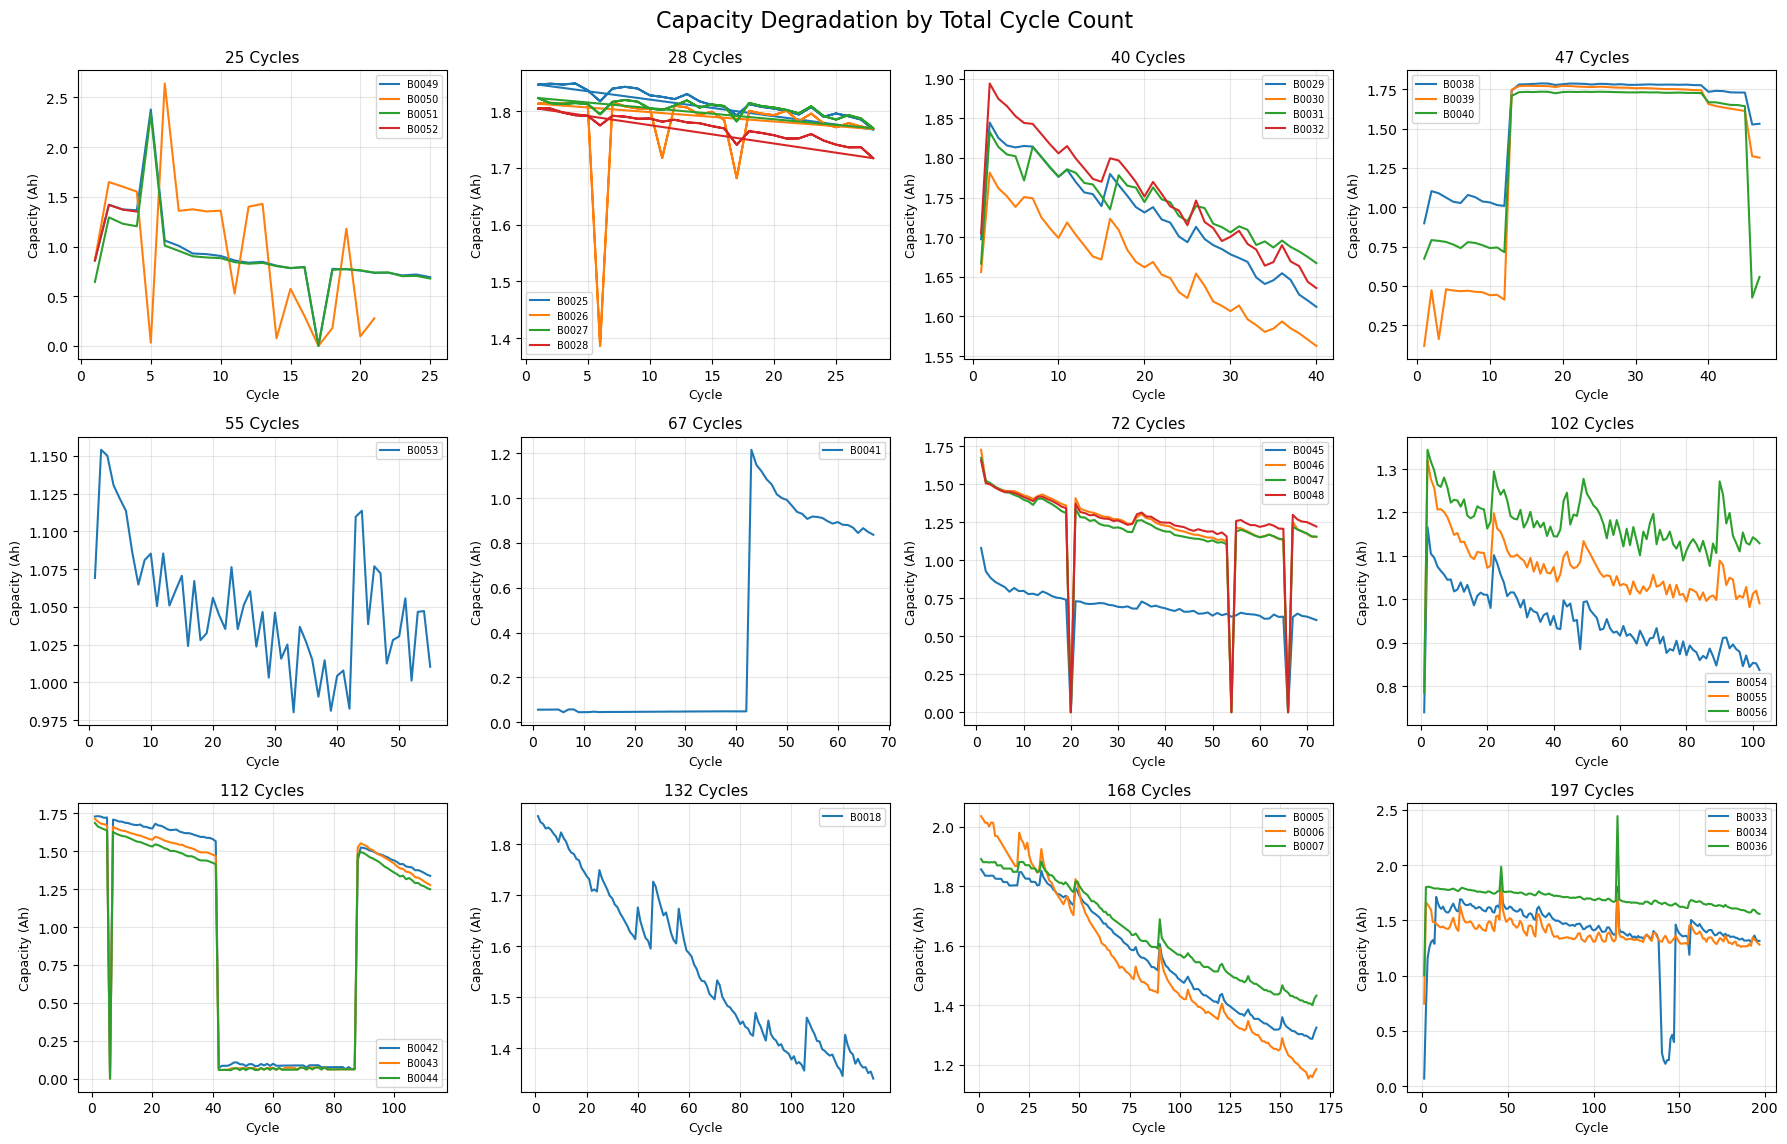

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load your processed dataset ===
df = pd.read_csv("Data/battery_cycles_summary.csv")

# === Compute total number of cycles per battery ===
cycle_counts = df.groupby("battery")["cycle"].max()

# === Get all unique cycle counts (sorted ascending) ===
unique_cycles = sorted(cycle_counts.unique())
print(f"Unique total cycle counts found: {unique_cycles}")
print(f"Total unique groups: {len(unique_cycles)}")
print("This is raw data demonstraion between Capacity and Number of Cycles")

# === Group batteries by their total cycle count ===
groups = {}
for battery, count in cycle_counts.items():
    groups.setdefault(count, []).append(battery)

# === Create a 3×4 subplot grid ===
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

# === Plot each group in one subplot ===
for i, total_cycle in enumerate(unique_cycles):
    ax = axes[i]
    batteries = groups[total_cycle]

    for b in batteries:
        sub = df[df["battery"] == b]
        ax.plot(sub["cycle"], sub["capacity_Ah"], label=b)

    ax.set_title(f"{total_cycle} Cycles", fontsize=11)
    ax.set_xlabel("Cycle", fontsize=9)
    ax.set_ylabel("Capacity (Ah)", fontsize=9)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=7)

# === Hide any empty subplots (if <12 groups) ===
for j in range(len(unique_cycles), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Capacity Degradation by Total Cycle Count", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Abnormal Cycle Groups Excluded

During the initial visualization of **capacity degradation curves grouped by total cycle count**, three groups were **manually** identified as **abnormal** and excluded from further analysis:

- **47 Cycles**
- **67 Cycles**
- **112 Cycles**

These groups display capacity behaviors that are physically implausible or inconsistent with normal lithium-ion degradation trends.

#### Observed Abnormalities
- **47 Cycles:** Capacity abruptly increases to an unrealistically high value (~full recovery) after early cycles, followed by sharp oscillations.  
- **67 Cycles:** Capacity remains near zero for ~40 cycles, then suddenly jumps to normal levels — suggesting measurement or data logging errors.  
- **112 Cycles:** Capacity drops to zero around midlife and later recovers — impossible under real electrochemical degradation, likely due to corrupted sensor readings.

#### Possible Causes
1. **Data acquisition or sensor calibration errors**  
   The recording sensors (current/voltage) might have desynchronized or temporarily failed, leading to incorrect capacity integration.
2. **Interrupted or restarted cycling experiments**  
   Experimental interruptions or restarts may have caused discontinuities or artificial resets in the cycle count and capacity recording.

These anomalies will be excluded from subsequent statistical analysis and modeling to ensure a reliable degradation trend.


In [27]:
# === Exclude abnormal batteries directly ===
exclude_batteries = ['B0042', 'B0043', 'B0044', 'B0041', 'B0038', 'B0039', 'B0040']

# before filter out
print(f"Before cleaning: {df['battery'].nunique()} unique batteries")

# filter out abnormal battery
df_cleaned = df[~df['battery'].isin(exclude_batteries)].copy()

# print
print(f"After cleaning: {df_cleaned['battery'].nunique()} unique batteries")
print(f"Removed batteries: {exclude_batteries}")

# replace df
df = df_cleaned


Before cleaning: 34 unique batteries
After cleaning: 27 unique batteries
Removed batteries: ['B0042', 'B0043', 'B0044', 'B0041', 'B0038', 'B0039', 'B0040']


Unique total cycle counts found: [np.int64(25), np.int64(28), np.int64(40), np.int64(55), np.int64(72), np.int64(102), np.int64(132), np.int64(168), np.int64(197)]
Total unique groups: 9
This is raw data demonstraion between Capacity and Number of Cycles


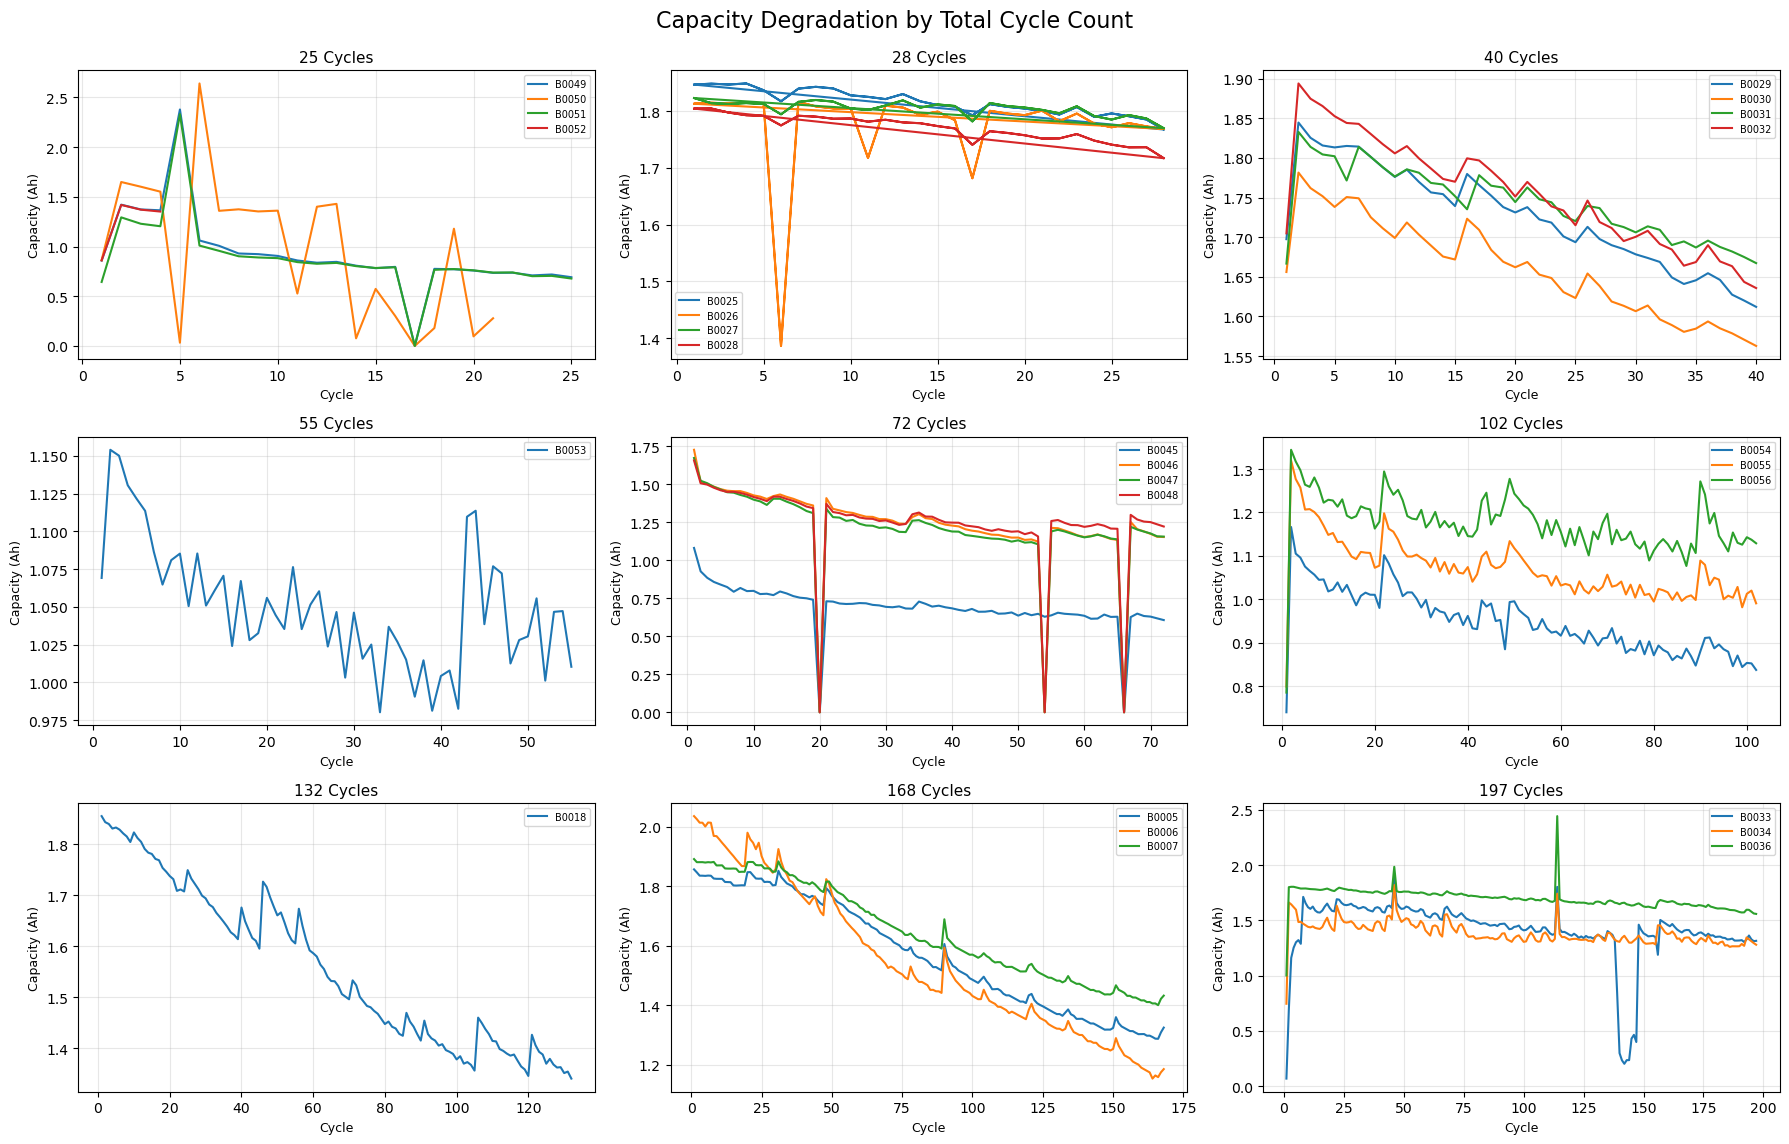

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# === Compute total number of cycles per battery ===
cycle_counts = df.groupby("battery")["cycle"].max()

# === Get all unique cycle counts (sorted ascending) ===
unique_cycles = sorted(cycle_counts.unique())
print(f"Unique total cycle counts found: {unique_cycles}")
print(f"Total unique groups: {len(unique_cycles)}")
print("This is raw data demonstraion between Capacity and Number of Cycles")

# === Group batteries by their total cycle count ===
groups = {}
for battery, count in cycle_counts.items():
    groups.setdefault(count, []).append(battery)

# === Create a 3×4 subplot grid ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# === Plot each group in one subplot ===
for i, total_cycle in enumerate(unique_cycles):
    ax = axes[i]
    batteries = groups[total_cycle]

    for b in batteries:
        sub = df[df["battery"] == b]
        ax.plot(sub["cycle"], sub["capacity_Ah"], label=b)

    ax.set_title(f"{total_cycle} Cycles", fontsize=11)
    ax.set_xlabel("Cycle", fontsize=9)
    ax.set_ylabel("Capacity (Ah)", fontsize=9)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=7)

# === Hide any empty subplots (if <12 groups) ===
for j in range(len(unique_cycles), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Capacity Degradation by Total Cycle Count", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Capacity Trend Interpretation

Although the overall trend of discharge capacity decreases with increasing cycle number, some batteries exhibit temporary rises or irregular fluctuations.  
These non-monotonic patterns are common in real-world battery aging data and can be explained by the following factors:

#### (a) **Measurement Noise**
- Capacity $ Q = \int I dt$ is computed by integrating current over time.  
- Small variations in current measurement or sampling interval can introduce random numerical errors.  
- These errors cause minor spikes or dips in the estimated capacity, without representing true physical changes.

#### (b) **Temperature Fluctuation**
- Battery capacity is temperature-dependent: higher temperature enhances electrochemical reactions, increasing apparent capacity.  
- Conversely, lower temperature reduces reaction rates, leading to temporary capacity drops.  
- As a result, short-term oscillations appear in the degradation curve due to temperature variations during testing.

#### (c) **Rest and Recovery Effect**
- During resting phases between charge–discharge cycles, ions redistribute more uniformly within the electrodes.  
- This relaxation process can temporarily restore part of the lost capacity, producing a small rebound before continuing to decline.  
- Such “capacity recovery” phenomena are widely documented in electrochemical aging studies


## Approaches of Outliers Detection

C:\Users\lijun\AppData\Local\Temp\ipykernel_5116\1626321935.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=6, loc="best")


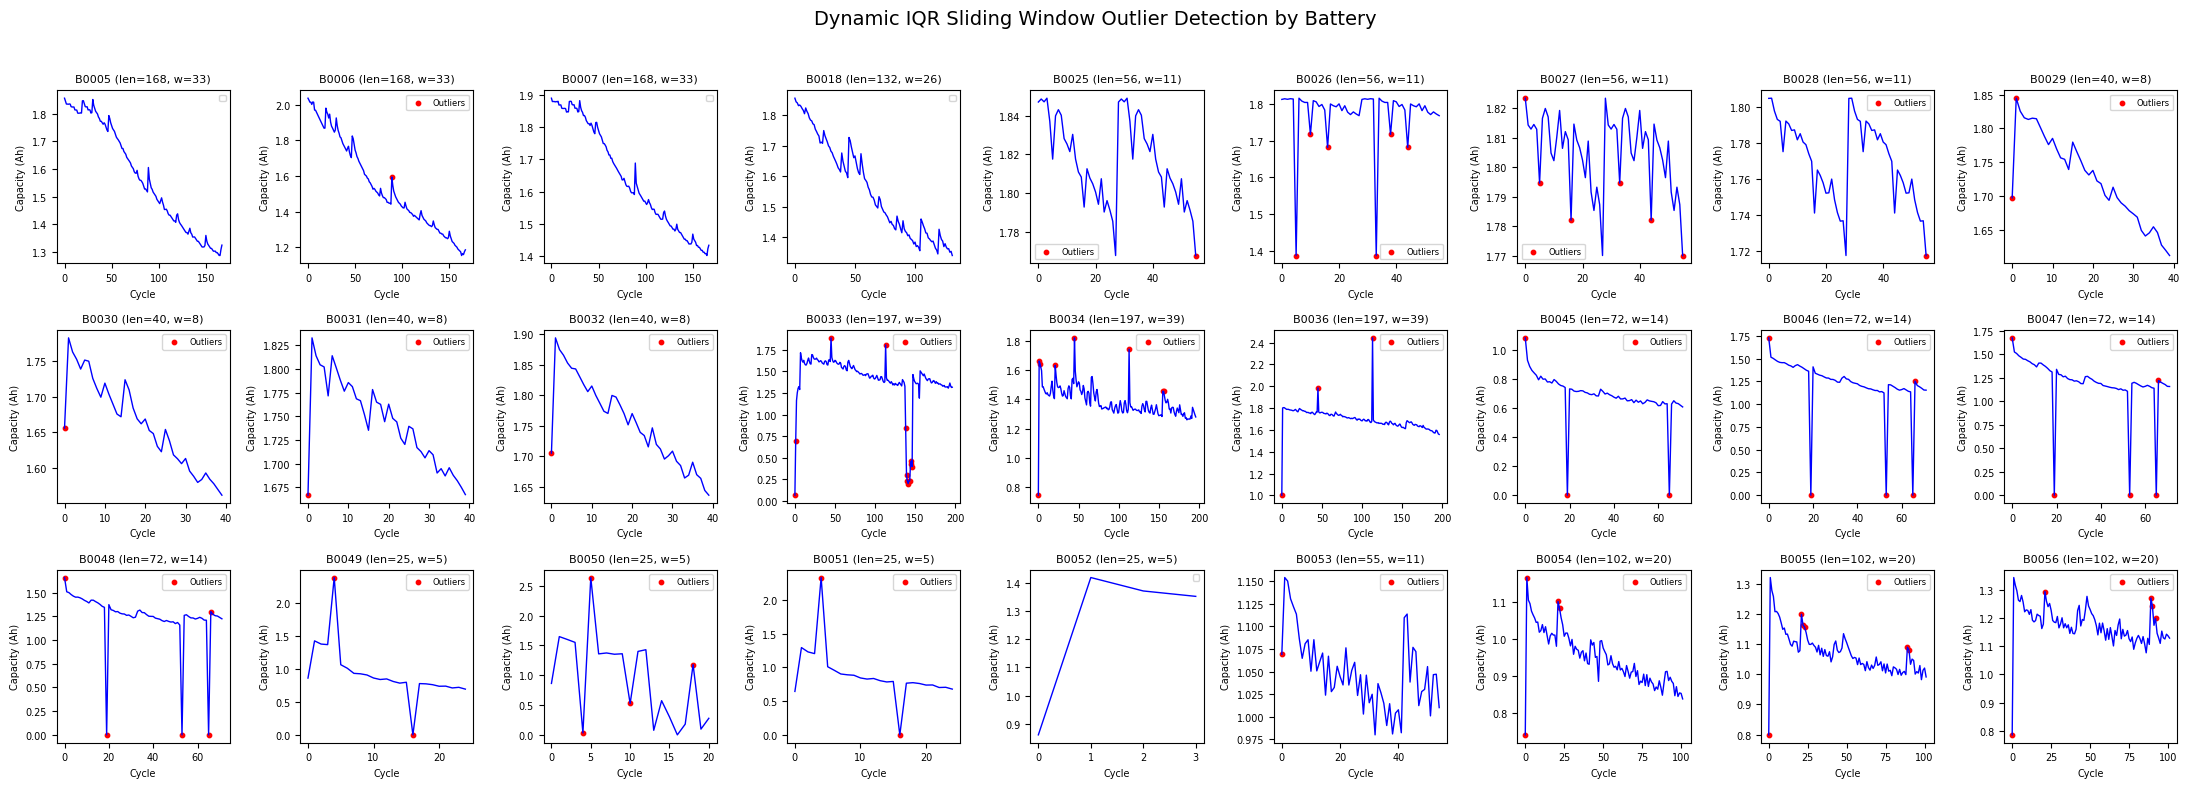

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# === Dynamic Sliding-Window IQR Outlier Detection Function ===
def detect_outliers_iqr_sliding(series, ratio=0.1, iqr_thresh=1.5):
    """
    Perform median-IQR based sliding-window outlier detection for a single time series.
    Parameters:
        series: pd.Series, the capacity sequence
        ratio: proportion of total sequence length to use as the window (e.g., 0.1 = 10%)
        iqr_thresh: threshold multiplier for the IQR rule
    Returns:
        outlier_indices: indices of detected outliers
        window_size: the actual window size used
    """
    outlier_indices = []
    series = series.reset_index(drop=True)
    n = len(series)
    
    # Dynamic window: at least 5, not exceeding half of the total length
    window = int(max(5, min(n * ratio, n // 2)))
    
    for i in range(n):
        start = max(0, i - window // 2)
        end = min(n, i + window // 2 + 1)
        window_data = series[start:end]

        # Compute IQR statistics
        q1 = np.percentile(window_data, 25)
        q3 = np.percentile(window_data, 75)
        iqr = q3 - q1
        lower = q1 - iqr_thresh * iqr
        upper = q3 + iqr_thresh * iqr

        # Mark point as outlier if outside range
        if series.iloc[i] < lower or series.iloc[i] > upper:
            outlier_indices.append(i)
    
    return np.array(outlier_indices), window


# === Parameters ===
window_ratio = 0.2   # Each battery uses a window equal to 20% of its total cycle length
iqr_threshold = 1.5

# === Initialization ===
outlier_summary = []
num_batteries = df["battery"].nunique()
cols = 9
rows = math.ceil(num_batteries / cols)

# === Create figure ===
fig, axes = plt.subplots(rows, cols, figsize=(22, 8))
axes = axes.flatten()

# === Run detection and plotting for each battery ===
for idx, (battery_id, group) in enumerate(df.groupby("battery")):
    capacity_series = group["capacity_Ah"].reset_index(drop=True)
    n_cycles = len(capacity_series)
    
    # Perform dynamic IQR-based outlier detection
    outliers, window_used = detect_outliers_iqr_sliding(capacity_series, ratio=window_ratio, iqr_thresh=iqr_threshold)
    
    # Record statistics
    outlier_summary.append({
        "battery": battery_id,
        "num_cycles": n_cycles,
        "window_used": window_used,
        "num_outliers": len(outliers),
        "outlier_indices": outliers
    })

    # Plot each battery
    ax = axes[idx]
    ax.plot(capacity_series.values, color="blue", linewidth=1)
    if len(outliers) > 0:
        ax.scatter(outliers, capacity_series.iloc[outliers], color="red", s=10, label="Outliers")
    ax.set_title(f"{battery_id} (len={n_cycles}, w={window_used})", fontsize=8)
    ax.set_xlabel("Cycle", fontsize=7)
    ax.set_ylabel("Capacity (Ah)", fontsize=7)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.legend(fontsize=6, loc="best")

# === Remove empty subplots ===
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Dynamic IQR Sliding Window Outlier Detection by Battery", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# === Output summary table ===
outlier_df = pd.DataFrame(outlier_summary)
# display(outlier_df)


### Outlier Detection Methodology

- We detect abnormal capacity readings using a **dynamic sliding window** approach, where the window size is defined as a fixed ratio (20%) of each battery’s total number of cycles.  
  This ensures the detection sensitivity remains consistent across batteries with different sequence lengths.

- For every point within a capacity time series, we take its surrounding window of data and compute the **median**, **first quartile (Q1)**, and **third quartile (Q3)**.

- We then calculate the **interquartile range (IQR = Q3 − Q1)** and define the acceptable range as `[Q1 − 1.5×IQR, Q3 + 1.5×IQR]`.  
  Any capacity value outside this range is marked as an outlier.

- This **median–IQR method** is more robust than mean–standard deviation approaches, as it minimizes the influence of extreme spikes or measurement noise in local windows.

- Finally, all detected outliers are **visualized as red points** on each battery’s capacity degradation curve in a 3×9 subplot matrix, allowing intuitive inspection of where anomalies occur within each time series.



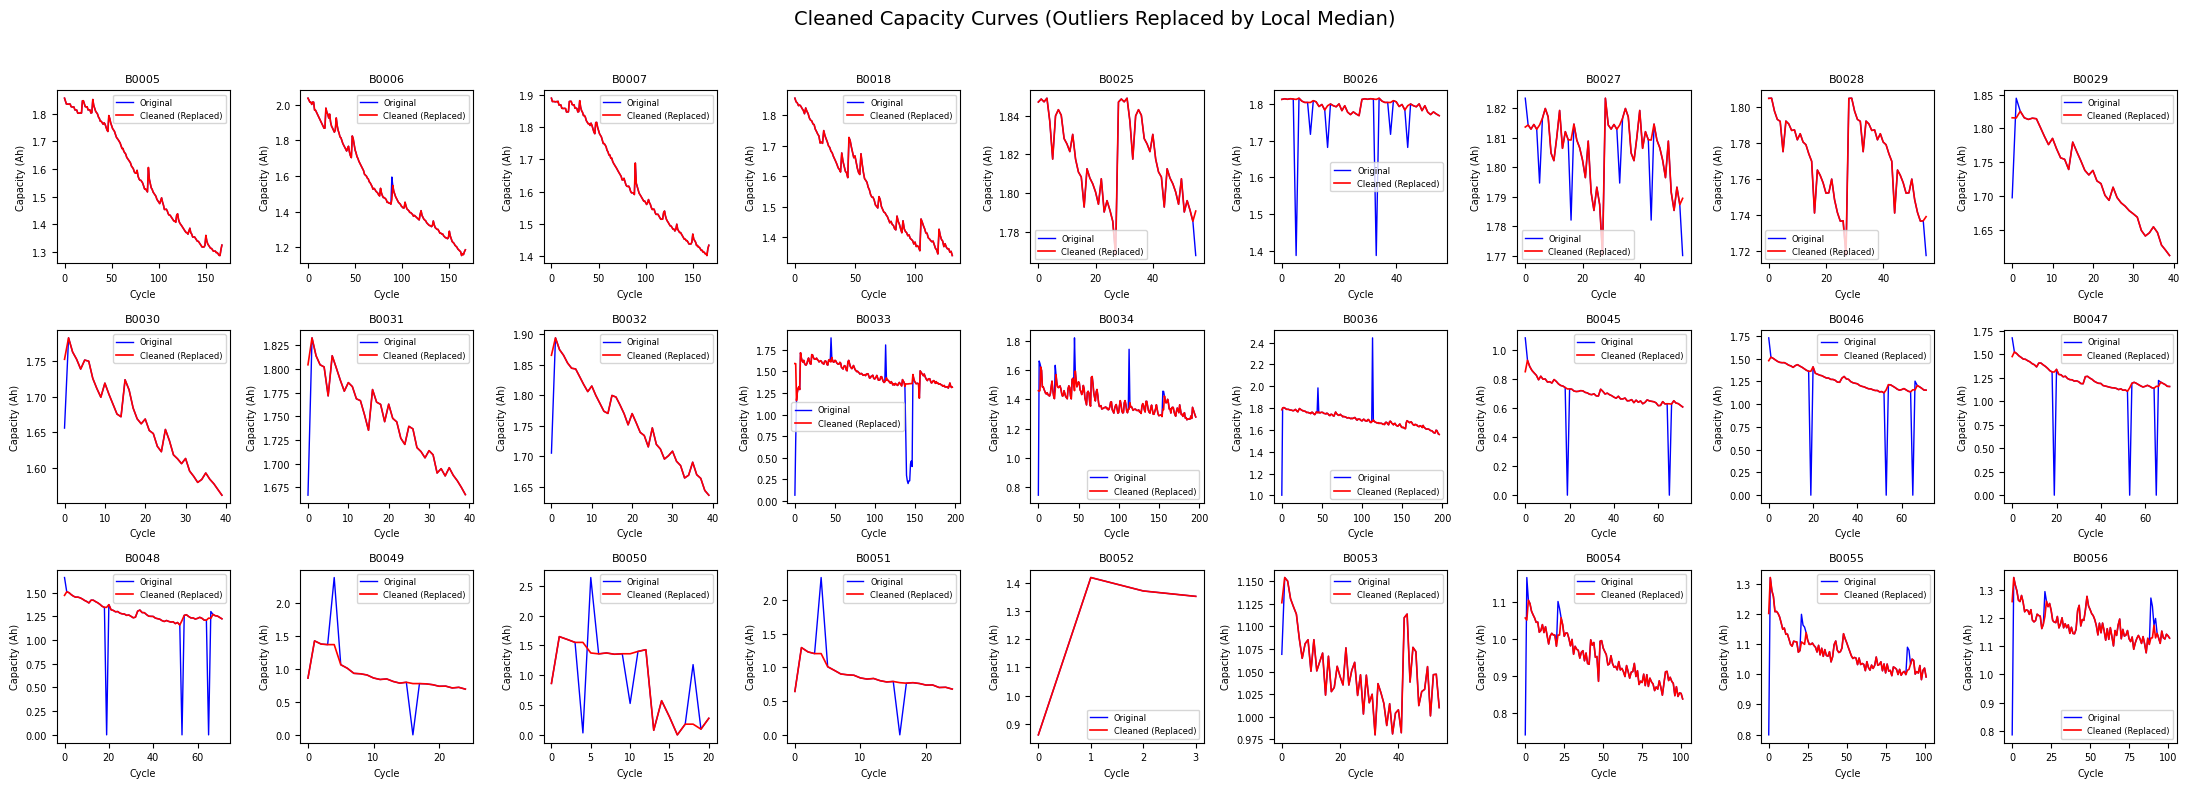

,battery,num_cycles,window_used,num_outliers,outlier_indices
0,B0005,168,33,0,[]
1,B0006,168,33,1,[89]
2,B0007,168,33,0,[]
3,B0018,132,26,0,[]
4,B0025,56,11,1,[55]
5,B0026,56,11,6,"[5, 10, 16, 33, 38, 44]"
6,B0027,56,11,6,"[0, 5, 16, 33, 44, 55]"
7,B0028,56,11,1,[55]
8,B0029,40,8,2,"[0, 1]"
9,B0030,40,8,1,[0]


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# === Dynamic Sliding-Window IQR Outlier Detection + Replacement ===
def detect_and_replace_outliers_iqr_sliding(series, ratio=0.1, iqr_thresh=1.5):
    """
    Detect outliers using IQR-based sliding window and replace them with local median.
    Returns:
        cleaned_series: Series with outliers replaced by window median
        outlier_indices: Indices of replaced points
        window_size: Actual window used
    """
    series = series.copy()
    n = len(series)
    outlier_indices = []

    # Dynamic window: at least 5, at most half of total length
    window = int(max(5, min(n * ratio, n // 2)))

    cleaned_series = series.copy()

    for i in range(n):
        start = max(0, i - window // 2)
        end = min(n, i + window // 2 + 1)
        window_data = series.iloc[start:end]

        q1 = np.percentile(window_data, 25)
        q3 = np.percentile(window_data, 75)
        iqr = q3 - q1
        lower = q1 - iqr_thresh * iqr
        upper = q3 + iqr_thresh * iqr

        # Replace outliers with window median
        if series.iloc[i] < lower or series.iloc[i] > upper:
            outlier_indices.append(i)
            cleaned_series.iloc[i] = np.median(window_data)

    return cleaned_series, np.array(outlier_indices), window


# === Parameters ===
window_ratio = 0.2
iqr_threshold = 1.5

# === Create a copy of df for cleaned capacity ===
df_cleaned = df.copy()
df_cleaned["capacity_cleaned"] = df["capacity_Ah"]  # initialize as same as original

# === Track summary ===
outlier_summary = []

# === Loop over batteries and replace outliers in df_cleaned ===
for battery_id, group in df.groupby("battery"):
    capacity_series = group["capacity_Ah"]
    cleaned_series, outliers, window_used = detect_and_replace_outliers_iqr_sliding(
        capacity_series, ratio=window_ratio, iqr_thresh=iqr_threshold
    )

    # Update by index alignment (this fixes the earlier bug)
    df_cleaned.loc[group.index, "capacity_cleaned"] = cleaned_series.values

    # Save summary info
    outlier_summary.append({
        "battery": battery_id,
        "num_cycles": len(capacity_series),
        "window_used": window_used,
        "num_outliers": len(outliers),
        "outlier_indices": outliers
    })


# === Plot cleaned vs original ===
num_batteries = df["battery"].nunique()
cols = 9
rows = math.ceil(num_batteries / cols)
fig, axes = plt.subplots(rows, cols, figsize=(22, 8))
axes = axes.flatten()

for idx, (battery_id, group) in enumerate(df_cleaned.groupby("battery")):
    original = group["capacity_Ah"].reset_index(drop=True)
    cleaned = group["capacity_cleaned"].reset_index(drop=True)
    ax = axes[idx]
    ax.plot(original, color="blue", linewidth=1, label="Original")
    ax.plot(cleaned, color="red", linewidth=1.2, label="Cleaned (Replaced)")
    ax.set_title(f"{battery_id}", fontsize=8)
    ax.set_xlabel("Cycle", fontsize=7)
    ax.set_ylabel("Capacity (Ah)", fontsize=7)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.legend(fontsize=6, loc="best")

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Cleaned Capacity Curves (Outliers Replaced by Local Median)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# === Output summary table ===
outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)



In [31]:
# === Create final cleaned version (remove old column) ===
df_final = df_cleaned.drop(columns=["capacity_Ah"]).rename(columns={"capacity_cleaned": "capacity_Ah"})

# === Save as new CSV ===
output_path = "Data/battery_cycles_summary_no_outlier.csv"
df_final.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"Cleaned dataset (outliers replaced) saved successfully as: {output_path}")
print(f"Columns: {list(df_final.columns)}")
print(f"Total rows: {len(df_final)}")



Cleaned dataset (outliers replaced) saved successfully as: Data/battery_cycles_summary_no_outlier.csv
Columns: ['battery', 'cycle', 'charge_voltage_avg', 'charge_voltage_min', 'charge_voltage_max', 'charge_current_avg', 'charge_current_min', 'charge_current_max', 'charge_temp_avg', 'charge_temp_min', 'charge_temp_max', 'charge_duration_s', 'discharge_voltage_avg', 'discharge_voltage_min', 'discharge_voltage_max', 'discharge_current_avg', 'discharge_current_min', 'discharge_current_max', 'discharge_temp_avg', 'discharge_temp_min', 'discharge_temp_max', 'discharge_duration_s', 'RUL', 'capacity_Ah']
Total rows: 2360


- All detected outlier values were **replaced with the median capacity** computed from their corresponding local window, ensuring smooth degradation trends while preserving the original electrochemical behavior of each cell.  

## Approach 2


In [32]:
df

,battery,cycle,charge_voltage_avg,charge_voltage_min,charge_voltage_max,charge_current_avg,charge_current_min,charge_current_max,charge_temp_avg,charge_temp_min,...,discharge_voltage_max,discharge_current_avg,discharge_current_min,discharge_current_max,discharge_temp_avg,discharge_temp_min,discharge_temp_max,discharge_duration_s,capacity_Ah,RUL
0,B0005,1,4.187420,3.479394,4.209949,0.643455,-4.030268,1.514393,25.324079,24.167062,...,4.191492,-1.818702,-2.018015,0.000729,32.572328,24.325993,38.982181,3690.234,1.856487,167
1,B0005,2,4.058826,3.001951,4.213016,0.949043,-3.361983,1.515178,26.635623,24.528515,...,4.189773,-1.817560,-2.016821,0.002927,32.725235,24.685948,39.033398,3672.344,1.846327,166
2,B0005,3,4.058139,3.035879,4.212788,0.950529,-3.384408,1.516894,26.778176,24.600174,...,4.188187,-1.816487,-2.016574,0.001484,32.642862,24.734266,38.818797,3651.641,1.835349,165
3,B0005,4,4.058905,3.066145,4.212924,0.952312,-3.412263,1.517503,26.703204,24.493346,...,4.188461,-1.825589,-2.015936,0.001547,32.514876,24.652244,38.762305,3631.563,1.835263,164
4,B0005,5,4.058330,3.063766,4.212874,0.947728,-3.403625,1.516949,26.617004,24.420170,...,4.188299,-1.826114,-2.017426,0.001701,32.382349,24.518700,38.665393,3629.172,1.834646,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,B0056,98,4.182444,3.731536,4.200058,0.384759,-0.001947,1.501476,6.281539,3.322873,...,4.181822,-1.734600,-1.996556,0.003793,10.116013,6.485511,13.316711,2345.000,1.130219,4
2900,B0056,99,4.183031,3.733652,4.200285,0.383084,0.000647,1.501921,6.234004,3.382147,...,4.181950,-1.714621,-1.996388,0.003859,10.332244,4.439396,14.612811,2363.047,1.125872,3
2901,B0056,100,4.185137,3.771261,4.200213,0.385818,0.000622,1.501952,6.129910,3.292991,...,4.181791,-1.774353,-1.996668,0.003194,10.278021,6.342042,14.205466,2316.687,1.143011,2
2902,B0056,101,4.182427,3.728542,4.200659,0.387420,-0.000516,1.501671,6.318080,3.475716,...,4.173014,-1.761997,-1.996444,0.002816,10.263503,6.423916,13.862517,2322.000,1.137273,1


In [33]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def autoregression_outlier_detection(series, err_multiplier=3.0, min_points=5):
    y = series.values
    n = len(y)

    preds = np.full(n, np.nan)
    outliers = []

    for t in range(n):
        if t < min_points:
            continue
        
        X_train = np.arange(t).reshape(-1,1)
        y_train = y[:t]

        model = LinearRegression()
        model.fit(X_train, y_train)

        pred = model.predict(np.array([[t]]))[0]
        preds[t] = pred

        rmse = np.sqrt(np.mean((model.predict(X_train) - y_train)**2))

        if abs(y[t] - pred) > err_multiplier * rmse:
            outliers.append(t)

    return outliers, preds



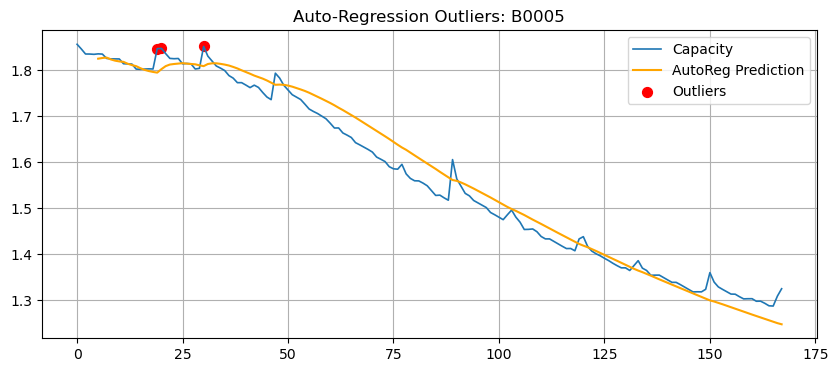

In [34]:
series = df[df["battery"]=="B0005"]["capacity_Ah"].reset_index(drop=True)

outliers, preds = autoregression_outlier_detection(series)

plt.figure(figsize=(10,4))
plt.plot(series, label="Capacity", linewidth=1.2)
plt.plot(preds, label="AutoReg Prediction", color="orange", linewidth=1.5)

if len(outliers) > 0:
    plt.scatter(outliers, series.iloc[outliers], color="red", s=50, label="Outliers")

plt.title("Auto-Regression Outliers: B0005")
plt.legend()
plt.grid(True)
plt.show()



## Threshold

Default: if |prediction - True y| > 3 × RMSE, then it considered as outlier

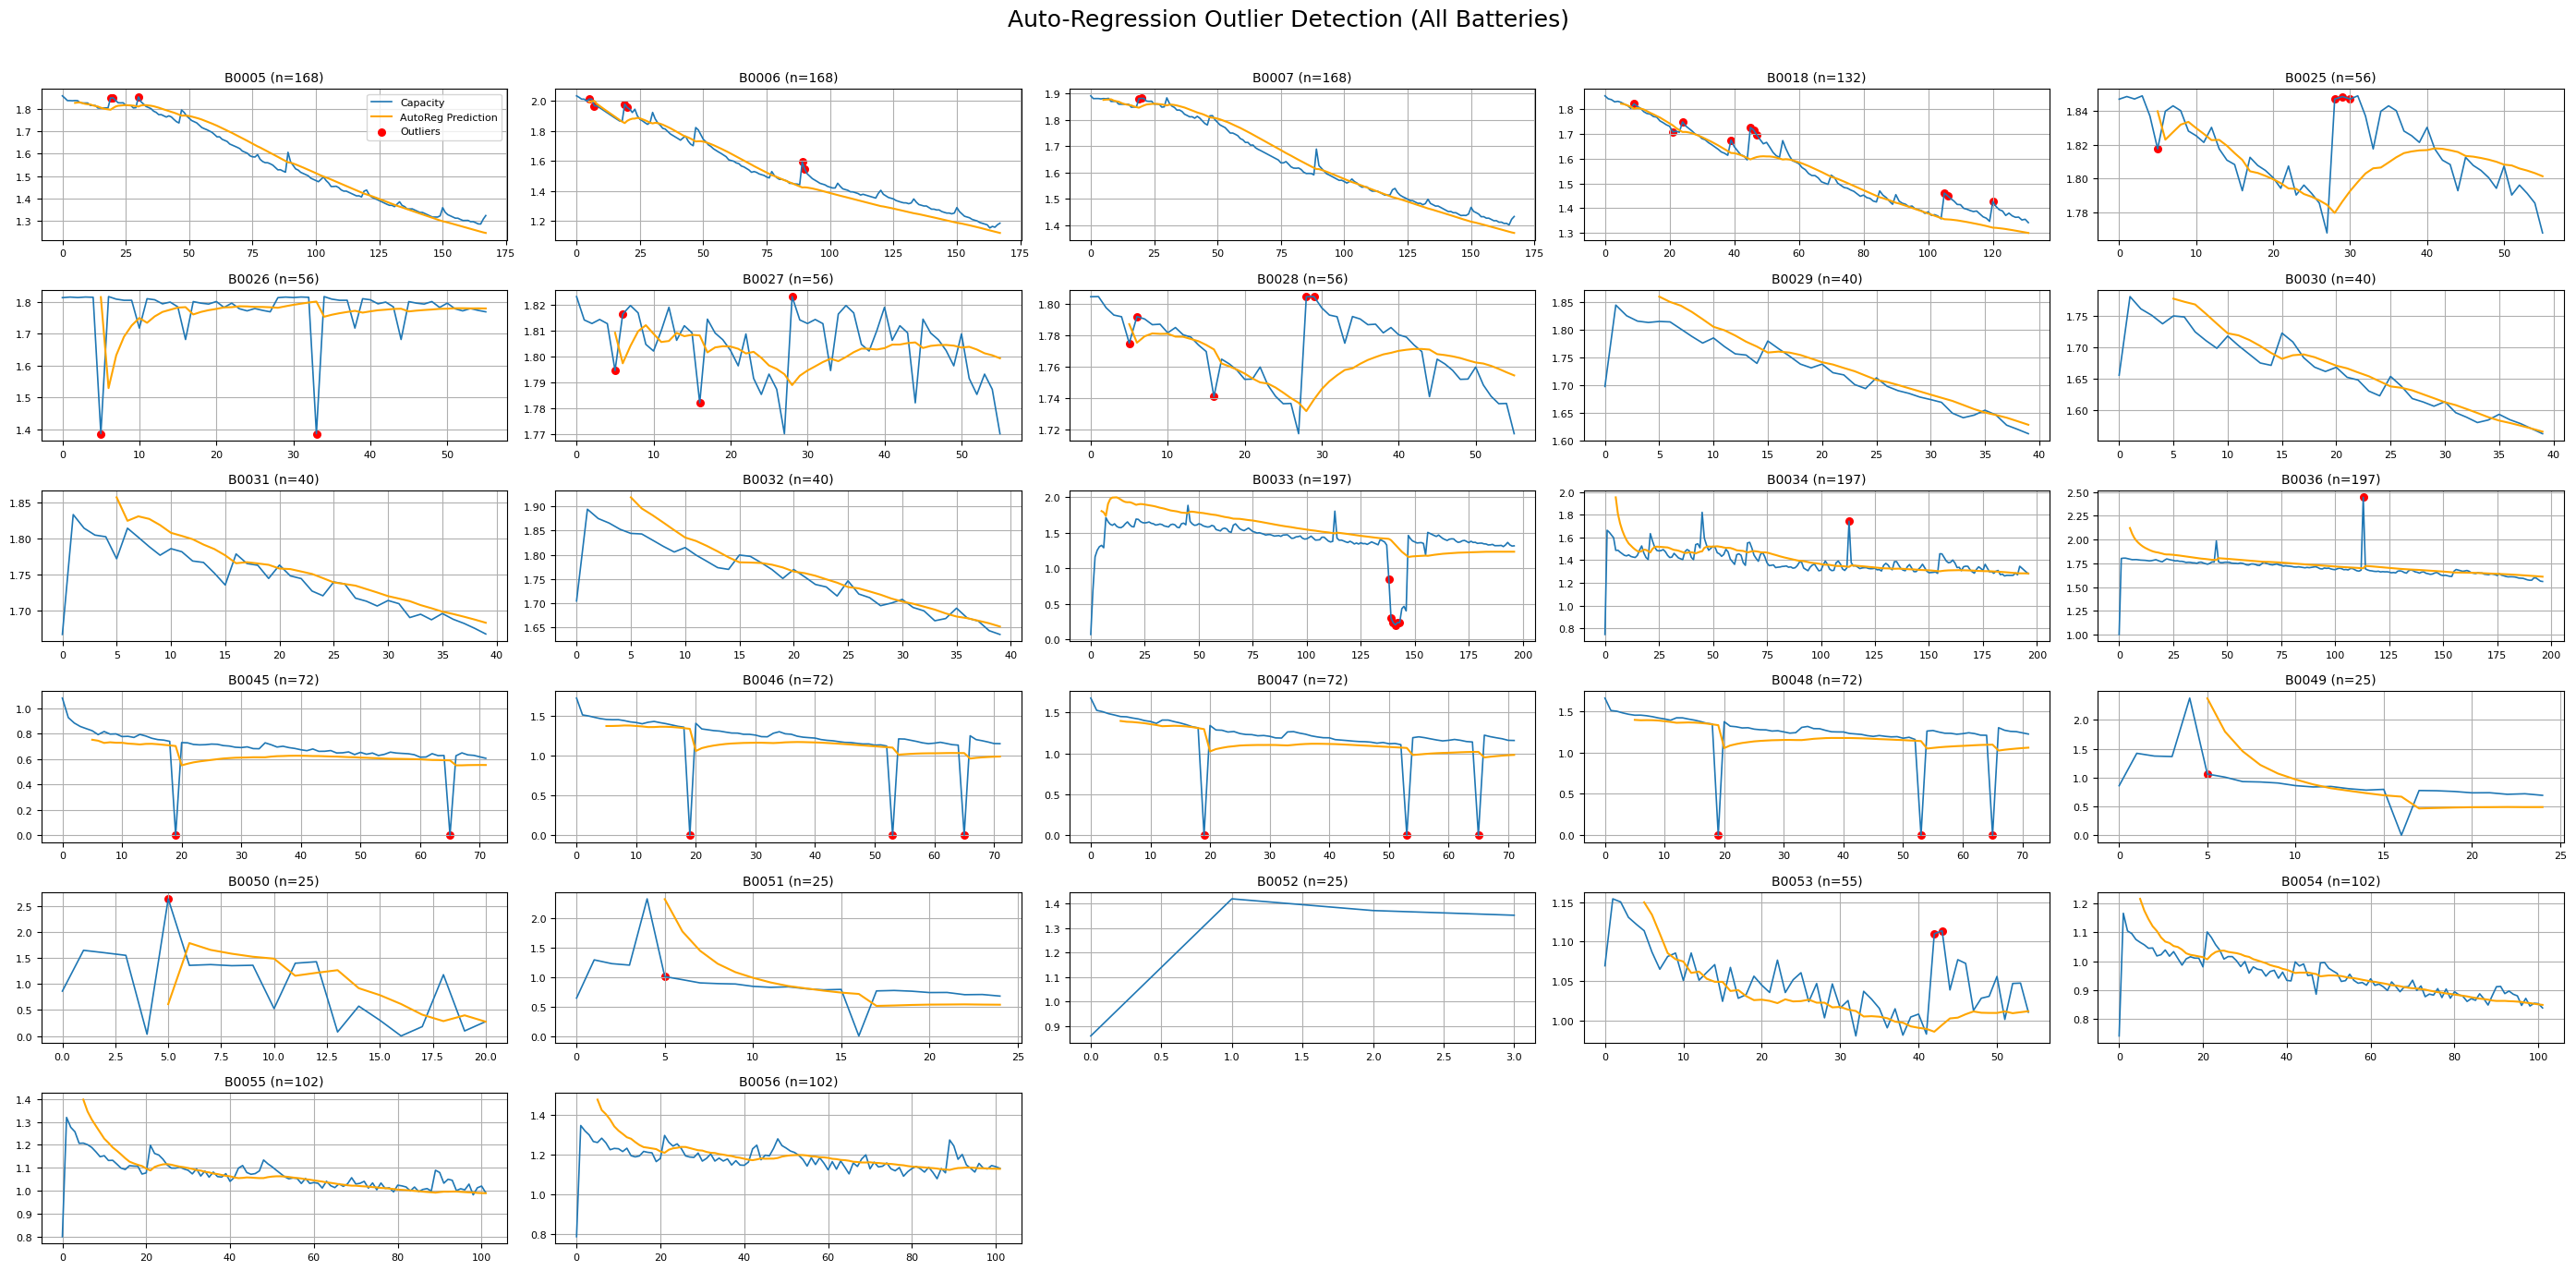

,battery,num_cycles,num_outliers,outlier_indices
0,B0005,168,3,"[19, 20, 30]"
1,B0006,168,6,"[5, 7, 19, 20, 89, 90]"
2,B0007,168,2,"[19, 20]"
3,B0018,132,10,"[9, 21, 24, 39, 45, 46, 47, 105, 106, 120]"
4,B0025,56,4,"[5, 28, 29, 30]"
5,B0026,56,2,"[5, 33]"
6,B0027,56,4,"[5, 6, 16, 28]"
7,B0028,56,5,"[5, 6, 16, 28, 29]"
8,B0029,40,0,[]
9,B0030,40,0,[]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

# --- Auto-Regression Outlier Detection ---
def autoregression_outlier_detection(series, err_multiplier=3.0, min_points=5):
    # Remove NaN values
    series = series.dropna().reset_index(drop=True)

    y = series.values
    n = len(y)

    preds = np.full(n, np.nan)
    outliers = []

    for t in range(n):
        if t < min_points:
            continue
        
        X_train = np.arange(t).reshape(-1,1)
        y_train = y[:t]

        model = LinearRegression()
        model.fit(X_train, y_train)

        pred = model.predict(np.array([[t]]))[0]
        preds[t] = pred

        rmse = np.sqrt(np.mean((model.predict(X_train) - y_train)**2))

        if abs(y[t] - pred) > err_multiplier * rmse:
            outliers.append(t)

    return outliers, preds



# ----------------------- MAIN LOOP FOR ALL BATTERIES -----------------------

batteries = sorted(df["battery"].unique())
num_batteries = len(batteries)

cols = 5
rows = math.ceil(num_batteries / cols)

fig, axes = plt.subplots(rows, cols, figsize=(28, 14))
axes = axes.flatten()

auto_outlier_results = []

for idx, battery_id in enumerate(batteries):

    group = df[df["battery"] == battery_id]["capacity_Ah"].reset_index(drop=True)
    outliers, preds = autoregression_outlier_detection(group)

    # Save results
    auto_outlier_results.append({
        "battery": battery_id,
        "num_cycles": len(group),
        "num_outliers": len(outliers),
        "outlier_indices": outliers
    })

    # --- PLOT ---
    ax = axes[idx]
    ax.plot(group, label="Capacity", linewidth=1.2)
    ax.plot(preds, label="AutoReg Prediction", color="orange", linewidth=1.5)

    if len(outliers) > 0:
        ax.scatter(outliers, group.iloc[outliers], color="red", s=30, label="Outliers")

    ax.set_title(f"{battery_id} (n={len(group)})", fontsize=10)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=8)

    
    if idx == 0:
        ax.legend(fontsize=8)


for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Auto-Regression Outlier Detection (All Batteries)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


auto_outlier_df = pd.DataFrame(auto_outlier_results)
auto_outlier_df


In [37]:
# =======================
# Replace Outliers & Save
# =======================

# Make a copy of df for replacement
df_auto_cleaned = df.copy()

for res in auto_outlier_results:
    battery_id = res["battery"]
    outliers = res["outlier_indices"]

    # capacity series for this battery
    group_idx = df[df["battery"] == battery_id].index
    series = df.loc[group_idx, "capacity_Ah"].reset_index(drop=True)

    # get predictions again (for replacement)
    _, preds = autoregression_outlier_detection(series)

    # replace outliers with their predicted values
    for oi in outliers:
        df_auto_cleaned.loc[group_idx[oi], "capacity_Ah"] = preds[oi]

# Save cleaned file
output_path = "Data/battery_cycles_summary_auto_cleaned.csv"
df_auto_cleaned.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"\nAuto-regression cleaned dataset saved to: {output_path}")



Auto-regression cleaned dataset saved to: Data/battery_cycles_summary_auto_cleaned.csv


## Check Missing Values for X Features

In [38]:
import pandas as pd

# === Load cleaned dataset ===
df = pd.read_csv("Data/battery_cycles_summary_no_outlier.csv")

# === Check for missing values ===
missing_summary = df.isna().sum()
print("=== Missing Value Summary (Before Fill) ===")
print(missing_summary[missing_summary > 0])

# === Fill missing values by forward-fill (and backward-fill as backup) ===
df_filled = df.fillna(method="ffill").fillna(method="bfill")

# === Verify after fill ===
print("\n=== Missing Value Summary (After Fill) ===")
print(df_filled.isna().sum()[df_filled.isna().sum() > 0])

# === Save final preprocessed dataset ===
output_path = "Data/battery_cycles_summary_no_outlier.csv"
df_filled.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"\nMissing values filled and dataset saved as: {output_path}")


=== Missing Value Summary (Before Fill) ===
charge_voltage_avg    11
charge_voltage_min    11
charge_voltage_max    11
charge_current_avg    11
charge_current_min    11
charge_current_max    11
charge_temp_avg       11
charge_temp_min       11
charge_temp_max       11
capacity_Ah           25
dtype: int64

=== Missing Value Summary (After Fill) ===
Series([], dtype: int64)

Missing values filled and dataset saved as: Data/battery_cycles_summary_no_outlier.csv


C:\Users\lijun\AppData\Local\Temp\ipykernel_5116\1211019946.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df.fillna(method="ffill").fillna(method="bfill")


In [39]:
import pandas as pd

# === Load cleaned dataset ===
df_auto = pd.read_csv("Data/battery_cycles_summary_auto_cleaned.csv")

# === Check for missing values ===
missing_summary = df_auto.isna().sum()
print("=== Missing Value Summary (Before Fill) ===")
print(missing_summary[missing_summary > 0])

# === Fill missing values by forward-fill (and backward-fill as backup) ===
df_filled = df_auto.fillna(method="ffill").fillna(method="bfill")

# === Verify after fill ===
print("\n=== Missing Value Summary (After Fill) ===")
print(df_filled.isna().sum()[df_filled.isna().sum() > 0])

# === Save final preprocessed dataset ===
output_path = "Data/battery_cycles_summary_auto_cleaned.csv"
df_filled.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"\nMissing values filled and dataset saved as: {output_path}")


=== Missing Value Summary (Before Fill) ===
charge_voltage_avg    11
charge_voltage_min    11
charge_voltage_max    11
charge_current_avg    11
charge_current_min    11
charge_current_max    11
charge_temp_avg       11
charge_temp_min       11
charge_temp_max       11
capacity_Ah           25
dtype: int64

=== Missing Value Summary (After Fill) ===
Series([], dtype: int64)

Missing values filled and dataset saved as: Data/battery_cycles_summary_auto_cleaned.csv


C:\Users\lijun\AppData\Local\Temp\ipykernel_5116\2219661137.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_auto.fillna(method="ffill").fillna(method="bfill")


## Model Updates

## **Linear Regression**

### Evaluation Metrics

To assess the predictive performance of the regression models, three standard evaluation metrics are employed: **R²**, **MAE**, and **RMSE**. Each metric captures a different aspect of model accuracy and reliability.

- **R² (Coefficient of Determination)**  
  Measures how well the model explains the variance in the target variable.  
  It ranges from 0 to 1, where a higher value indicates a better fit between the predicted and actual values.  
  
  $R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$
    
  *Interpretation:* A high R² means the model captures most of the variability in the data.

- **MAE (Mean Absolute Error)**  
  Represents the average magnitude of errors in the predictions, without considering their direction.  
  It is computed as the mean of absolute differences between predicted and true values.  

  $MAE = \frac{1}{n}\sum |y_i - \hat{y}_i|$
  
  *Interpretation:* Lower MAE indicates better performance and higher prediction accuracy.

- **RMSE (Root Mean Squared Error)**  
  Measures the square root of the average squared differences between predictions and actual values.  
  RMSE penalizes large errors more heavily than MAE, making it sensitive to outliers.  
  
  $RMSE = \sqrt{\frac{1}{n}\sum (y_i - \hat{y}_i)^2}$
  
  *Interpretation:* Smaller RMSE reflects a model whose predictions are closer to the true observations on average.

**Summary:**  
- R² evaluates the model’s overall explanatory power (*fit quality*).  
- MAE reflects the model’s accuracy on average predictions.  
- RMSE captures the model’s stability and sensitivity to large deviations or outliers.

Overall, a good model should have a **high R²** and **low MAE/RMSE**, indicating strong explanatory power and accurate predictions.


## Original (No Outlier Detection)

Linear Regression Results:
R² Score:  0.8879
MAE:       0.1047
RMSE:      0.1520


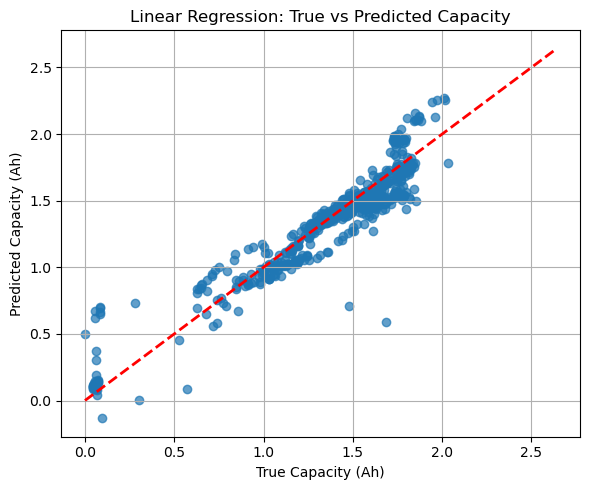

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
path = r"C:\Users\lijun\Downloads\ESE5971-Project\Data\battery_cycles_summary.csv"
df = pd.read_csv(path)

# ===== Remove rows where y is NaN =====
df = df.dropna(subset=["capacity_Ah"])

# ===== Remove unwanted columns =====
drop_cols = ["battery", "capacity_Ah", "RUL"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["capacity_Ah"]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number]).fillna(0)

# ===== Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Train model =====
model = LinearRegression()
model.fit(X_train, y_train)

# ===== Evaluate =====
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 

print("Linear Regression Results:")
print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"RMSE:      {rmse:.4f}")

# ===== Visualization =====
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("True Capacity (Ah)")
plt.ylabel("Predicted Capacity (Ah)")
plt.title("Linear Regression: True vs Predicted Capacity")
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest Regressor Results:
R² Score:  0.9836
MAE:       0.0174
RMSE:      0.0582


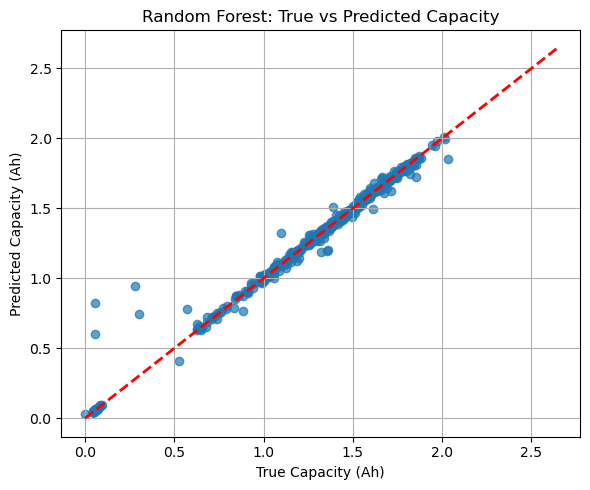

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
path = r"C:\Users\lijun\Downloads\ESE5971-Project\Data\battery_cycles_summary.csv"
df = pd.read_csv(path)

# ===== Remove rows where y is NaN =====
df = df.dropna(subset=["capacity_Ah"])

# ===== Remove unwanted columns =====
drop_cols = ["battery", "capacity_Ah", "RUL"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["capacity_Ah"]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number]).fillna(0)

# ===== Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Train model =====
rf = RandomForestRegressor(
    n_estimators=300,        # number of trees
    max_depth=None,         # let RF grow fully
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

rf.fit(X_train, y_train)

# ===== Evaluate =====
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Random Forest Regressor Results:")
print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"RMSE:      {rmse:.4f}")

# ===== Visualization =====
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("True Capacity (Ah)")
plt.ylabel("Predicted Capacity (Ah)")
plt.title("Random Forest: True vs Predicted Capacity")
plt.grid(True)
plt.tight_layout()
plt.show()


## Approach 1 (With IQR and Sliding Window Outlier Dectection Method)

Linear Regression Results:
R² Score:  0.8655
MAE:       0.0774
RMSE:      0.1111


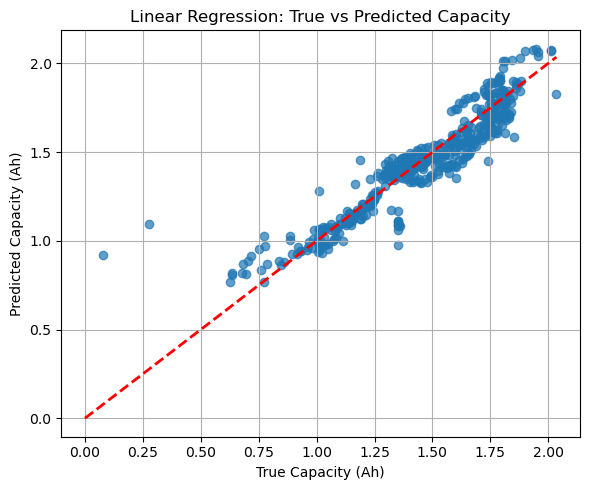

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
path = r"C:\Users\lijun\Downloads\ESE5971-Project\Data\battery_cycles_summary_no_outlier.csv"
df = pd.read_csv(path)

# ===== Remove unwanted columns =====
drop_cols = ["battery", "capacity_Ah", "RUL"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["capacity_Ah"]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number]).fillna(0)

# ===== Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Train model =====
model = LinearRegression()
model.fit(X_train, y_train)

# ===== Evaluate =====
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 

print("Linear Regression Results:")
print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"RMSE:      {rmse:.4f}")

# ===== Visualization =====
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("True Capacity (Ah)")
plt.ylabel("Predicted Capacity (Ah)")
plt.title("Linear Regression: True vs Predicted Capacity")
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest Regressor Results:
R² Score:  0.9863
MAE:       0.0151
RMSE:      0.0354


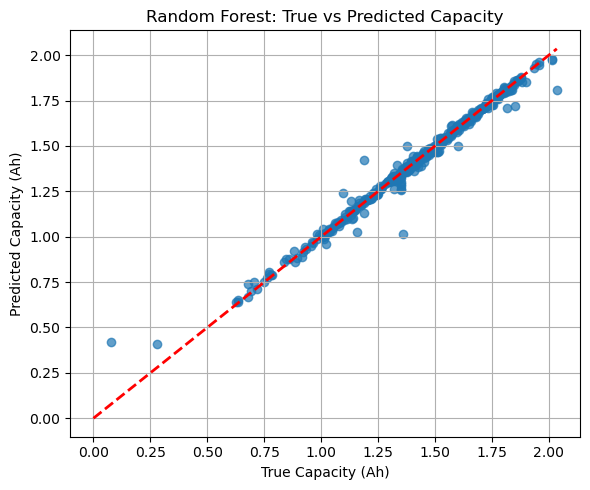

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
path = r"C:\Users\lijun\Downloads\ESE5971-Project\Data\battery_cycles_summary_no_outlier.csv"
df = pd.read_csv(path)

# ===== Remove unwanted columns =====
drop_cols = ["battery", "capacity_Ah", "RUL"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["capacity_Ah"]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number]).fillna(0)

# ===== Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Train model =====
rf = RandomForestRegressor(
    n_estimators=300,        # number of trees
    max_depth=None,         # let RF grow fully
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

rf.fit(X_train, y_train)

# ===== Evaluate =====
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Random Forest Regressor Results:")
print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"RMSE:      {rmse:.4f}")

# ===== Visualization =====
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("True Capacity (Ah)")
plt.ylabel("Predicted Capacity (Ah)")
plt.title("Random Forest: True vs Predicted Capacity")
plt.grid(True)
plt.tight_layout()
plt.show()


## Approach 2 (With auto-regression Outlier Dectection Method)

Linear Regression Results:
R² Score:  0.8270
MAE:       0.0840
RMSE:      0.1270


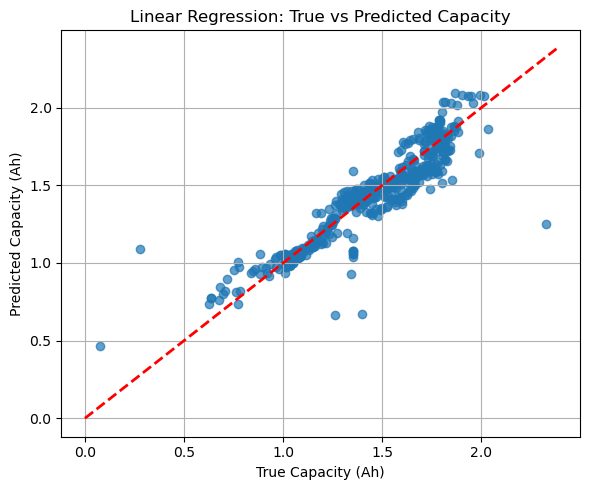

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
path = r"C:\Users\lijun\Downloads\ESE5971-Project\Data\battery_cycles_summary_auto_cleaned.csv"
df = pd.read_csv(path)

# ===== Remove rows where y is NaN =====
df = df.dropna(subset=["capacity_Ah"])

# ===== Remove unwanted columns =====
drop_cols = ["battery", "capacity_Ah", "RUL"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["capacity_Ah"]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number]).fillna(0)

# ===== Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Train model =====
model = LinearRegression()
model.fit(X_train, y_train)

# ===== Evaluate =====
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 

print("Linear Regression Results:")
print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"RMSE:      {rmse:.4f}")

# ===== Visualization =====
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("True Capacity (Ah)")
plt.ylabel("Predicted Capacity (Ah)")
plt.title("Linear Regression: True vs Predicted Capacity")
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest Regressor Results:
R² Score:  0.9460
MAE:       0.0203
RMSE:      0.0710


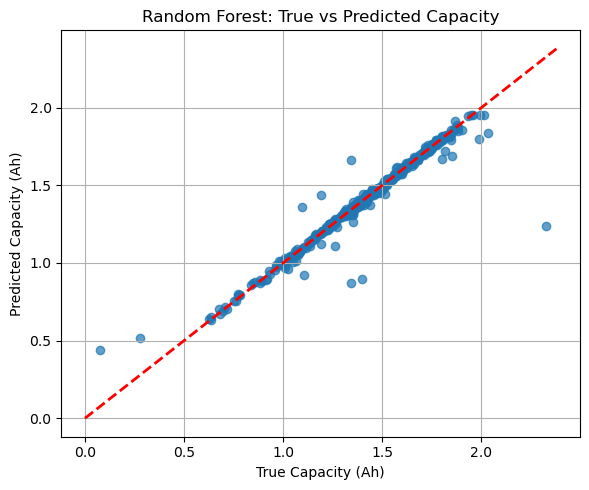

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
path = r"C:\Users\lijun\Downloads\ESE5971-Project\Data\battery_cycles_summary_auto_cleaned.csv"
df = pd.read_csv(path)

# ===== Remove unwanted columns =====
drop_cols = ["battery", "capacity_Ah", "RUL"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["capacity_Ah"]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number]).fillna(0)

# ===== Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Train model =====
rf = RandomForestRegressor(
    n_estimators=300,        # number of trees
    max_depth=None,         # let RF grow fully
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

rf.fit(X_train, y_train)

# ===== Evaluate =====
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Random Forest Regressor Results:")
print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"RMSE:      {rmse:.4f}")

# ===== Visualization =====
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("True Capacity (Ah)")
plt.ylabel("Predicted Capacity (Ah)")
plt.title("Random Forest: True vs Predicted Capacity")
plt.grid(True)
plt.tight_layout()
plt.show()


## k-Nearest Neighbors (kNN) Regression



The **k-Nearest Neighbors (kNN)** algorithm is a non-parametric regression method that predicts the target value of a given sample by averaging the target values of its *k* closest neighbors in the feature space.  

Unlike Linear Regression, kNN makes no assumptions about the data distribution or linear relationships among features — it relies purely on **distance-based similarity**.

**Key Characteristics:**
- The parameter *k* determines how many neighbors influence the prediction.  
  - Smaller *k* → more sensitive to noise (high variance).  
  - Larger *k* → smoother predictions (high bias).
- The most common distance metric is **Euclidean distance**, but others (like Manhattan or Minkowski) can be used.
- kNN works well when the dataset is **locally smooth** but may perform poorly in high-dimensional spaces due to the *curse of dimensionality*.

**Mathematical Formulation:**  
For a query sample $x_q$, the predicted value is:
$
\hat{y}_q = \frac{1}{k} \sum_{x_i \in N_k(x_q)} y_i
$
where $N_k(x_q)$ is the set of *k* nearest neighbors of $x_q$.

The model performance is evaluated using the same metrics — **R²**, **MAE**, and **RMSE** — to ensure consistent comparison with Linear Regression.


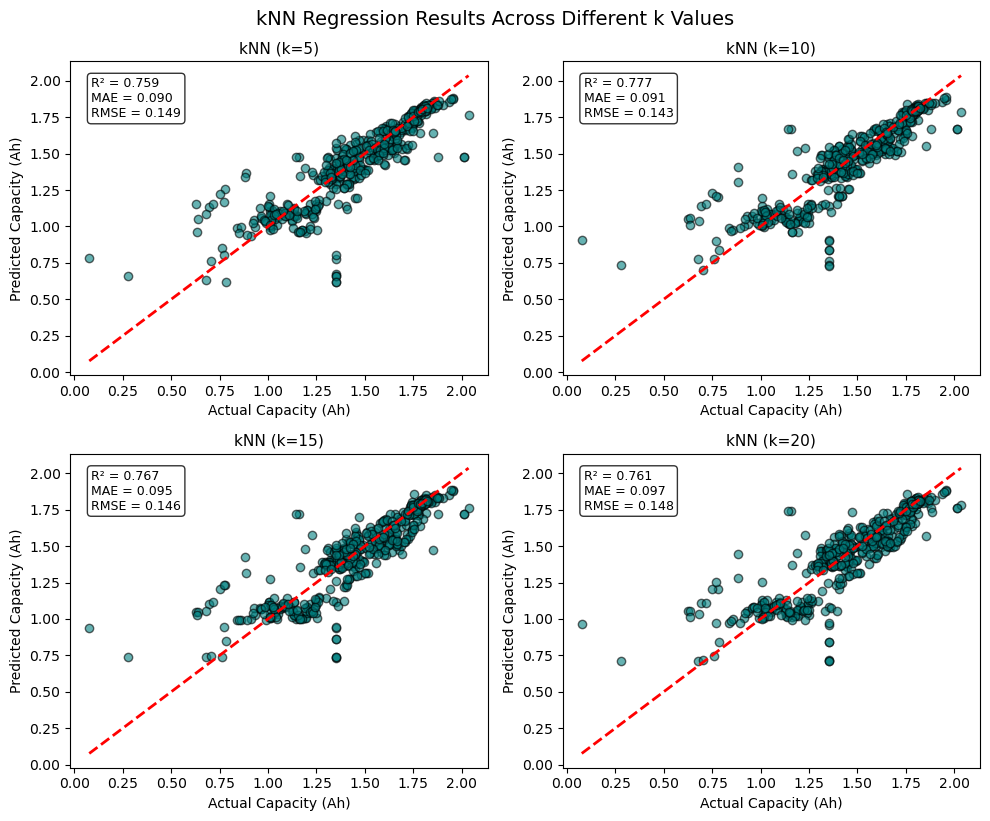

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# === Load dataset ===
path = "Data/battery_cycles_summary_no_outlier.csv"
df = pd.read_csv(path)

# === Prepare features and target ===
drop_cols = ["battery", "RUL", "capacity_Ah"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["capacity_Ah"]

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Define k values ===
k_values = [5, 10, 15, 20]

# === Create subplots (2x2 matrix) ===
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# === Loop over each k and plot results ===
for i, k in enumerate(k_values):
    # Train model
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Compute metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))

    # Plot
    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.6, color="teal", edgecolors="k")
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
    ax.set_title(f"kNN (k={k})", fontsize=11)
    ax.set_xlabel("Actual Capacity (Ah)")
    ax.set_ylabel("Predicted Capacity (Ah)")

    # Annotate metrics directly on the plot
    ax.text(0.05, 0.95,
            f"R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}",
            transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.suptitle("kNN Regression Results Across Different k Values", fontsize=14, y=1.02)
plt.show()


## Next Steps

Our next steps will focus on improving both the **Outlier Detection** method and the **predictive modeling framework**. The current workflow serves as a foundational baseline, and the upcoming phases aim to enhance robustness, accuracy, and interpretability.

#### 1. Refining Outlier Detection for Time Series
- The current IQR-based sliding window method provides a basic statistical baseline but lacks trend awareness.  
- As an improvement, we plan to implement a **Linear Regression–based Outlier Detection** approach, where for each time step, a short-term regression model (e.g., using the previous 10 points) is fitted, and the predicted value is compared with the actual observation.  
  - If the deviation exceeds a defined threshold, the point will be flagged as an outlier.  
  - This method inherently accounts for the downward degradation trend in capacity, reducing false positives that the IQR method may misclassify due to trend direction.  
- In addition, we will explore a **Local Outlier Factor (LOF)**–based approach, which measures the local density deviation of each point relative to its neighbors.  
  - Points that are much less “dense” than their local neighborhood are flagged as anomalies. Used KNN to calculate the "dense".
  - Compared to regression-based methods, LOF can capture non-linear and irregular anomalies while remaining lightweight and data-efficient.

#### 2. Expanding the Predictive Modeling Scope
- Beyond **Linear Regression** and **kNN**, we will introduce ensemble regression models such as **Random Forest Regressor**, **XGBoost**. 
- The goal is to assess how tree-based ensemble methods compare to simpler models in terms of generalization performance and robustness to noise.  
- All models will be evaluated under the same regression metrics — **R²**, **MAE**, and **RMSE** — to ensure consistency and comparability.



